In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob
from pathlib import Path
from astropy.io import fits
from scipy.optimize import curve_fit

class readerFile:

    def __init__(self, file_path):
        self.file_path = file_path
        header, data = self.__read_file()

        hdu = fits.PrimaryHDU(data)
        self.__get_header_format(header, hdu)

        hdul = fits.HDUList([hdu])
        # self.header = header
        self.hdul = hdul

    def read(self):
        return self.hdul
        

    def __read_file(self):
        header = []
        
        with open(self.file_path, 'r') as file:
            lines = file.readlines()
            
            # Skip the first empty line
            lines = lines[1:]  # Skip first empty line
            
            # Now separate the header and content
            header_found = False
            for i, line in enumerate(lines):
                if header_found:
                    break
                elif line.strip() == '':  # Empty line indicates end of header
                    header_found = True
                else:
                    header.append(line.strip())
    
        data = np.genfromtxt(self.file_path, unpack=True, skip_header=107)
        return header, data

    def __parse_value(self, value):
        """Parse the string value to the appropriate type (float, int, or str)."""
        value_stripped = value.strip()  # Remove any leading/trailing whitespace
        # Try converting to an int first
        if value_stripped.isdigit():  # Check if it's a positive integer
            return int(value_stripped)
        # Try converting to a float next
        try:
            return float(value_stripped)
        except ValueError:
            return value_stripped  # Return as string if not float or int


    def __get_header_format(self, header, hdu):

        for line in header:
            param_name, param_val = line.split(':')
            parsed_value = self.__parse_value(param_val)

            hdu.header[param_name] = parsed_value

        return

In [25]:
mypath = r"C:\Users\nicol\Documents\Astro_Exp\Radio 1\datos_espectros\sdf*"
# spectra_paths = [str(f) for f in mypath.iterdir() if f.is_file()]
spectra_paths = sorted(glob.glob(mypath))


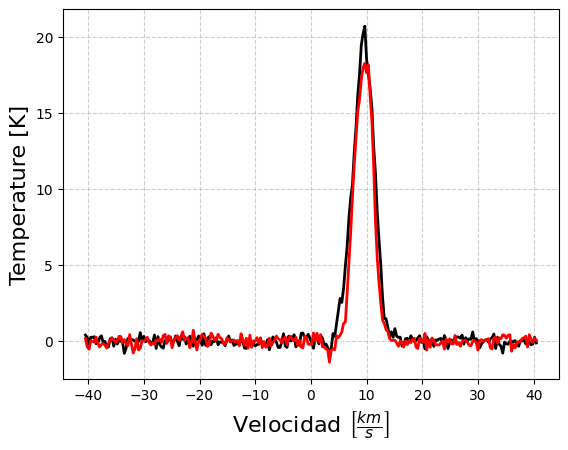

In [23]:
spectra_FITS = []
for j in spectra_paths:
    spectra_j = readerFile(j).read()
    spectra_FITS += spectra_j

spectra_xy = []
for i in spectra_FITS:
    hdr = i.header
    lii, bii = hdr['LII'], hdr['BII']
    spectra_xy.append([lii, bii])

spec_v = []
spec_T = []
for i in range(len(spectra_FITS)):
    v, T = spectra_FITS[i].data
    spec_v.append(v)
    spec_T.append(T)


plt.plot(spec_v[0], spec_T[0], color="black", linestyle="-", linewidth=2)
plt.plot(spec_v[1], spec_T[1], color="red", linestyle="-", linewidth=2)
plt.xlabel(r"Velocidad $\left[ \frac{km}{s}\right]$", fontsize=16)
plt.ylabel(r"Temperature [K]", fontsize=16)

plt.grid(True, linestyle="--", alpha=0.6)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()



In [4]:
stack_T = np.stack(spec_T)
sumas_T = np.cumsum(spec_T, axis = 0)

div = np.arange(1, len(spec_T)+1).reshape(-1, 1)

means_T = sumas_T/div


In [5]:
def fn_gauss(x,T0,mean,stdv):
    return T0*np.exp(-((x-mean)**2)/(2*(stdv**2)))

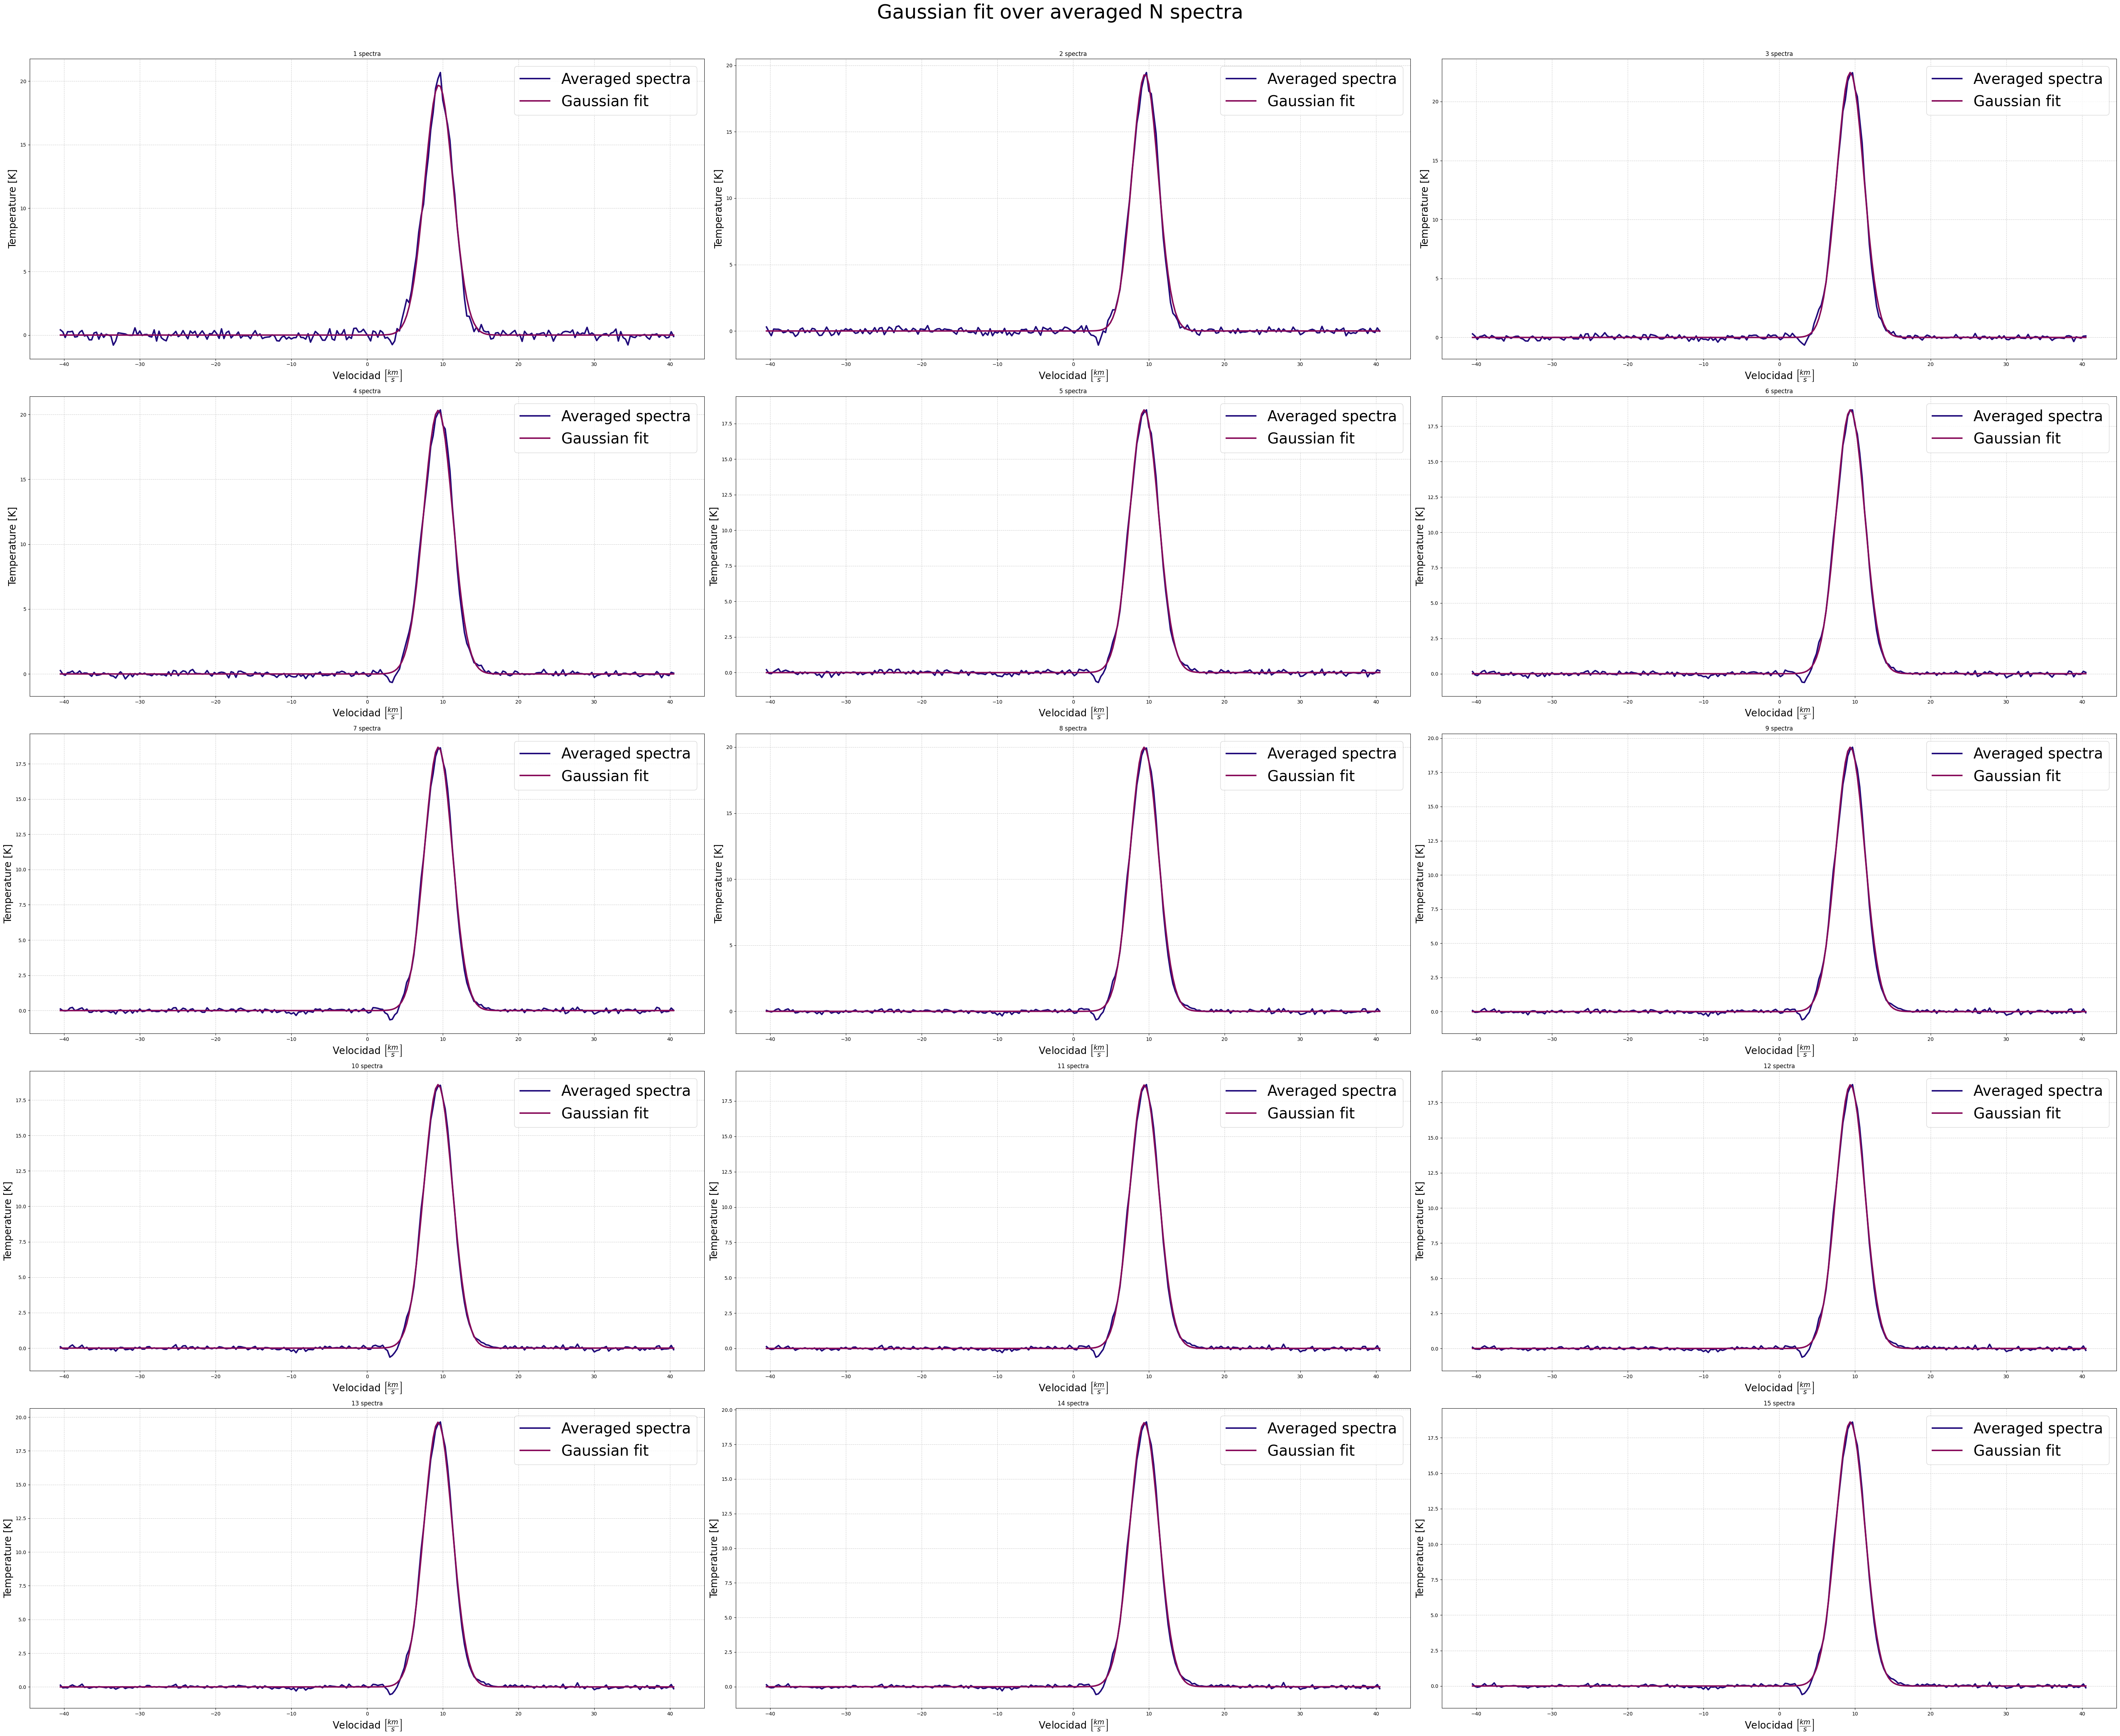

[0.34561934 0.25453143 0.2398201  0.23593678 0.17336186 0.16460438
 0.17378187 0.17848932 0.1816478  0.15353688 0.15262031 0.15402997
 0.15839386 0.16090212 0.14462833]


In [ ]:
rms_i = []

fig, axes = plt.subplots(5, 3, figsize = (60, 50))

axes = axes.flatten()

for i in range(len(spec_v)):
    fg = [20, 10, 1] 

    coefs,cov = curve_fit(fn_gauss, v, means_T[i], p0=fg) 

    t0, M, S = coefs[0], coefs[1], coefs[2]

    gauss_fit = fn_gauss(v, t0, M, S)

    resta = means_T[i] - gauss_fit

    rms = np.std(resta)

    rms_i.append(rms)
    #rms_i.append(np.sqrt(np.mean(resta**2)))

    axes[i].plot(spec_v[i], means_T[i], color = "#1f097a", linestyle = "-", linewidth = 3, label = 'Averaged spectra')
    axes[i].plot(spec_v[i], gauss_fit, color = "#870959", linestyle = "-", linewidth = 3, label = 'Gaussian fit')
        
    axes[i].set_xlabel(r"Velocity $\left[ \frac{km}{s}\right]$", fontsize=20)
    axes[i].set_ylabel(r"Temperature [K]", fontsize=20)

    axes[i].set_title(str(i + 1) + ' spectra')

    axes[i].grid(True, linestyle="--", alpha=0.6)
    axes[i].tick_params(labelsize=10)
    axes[i].legend(fontsize=30)
   
fig.suptitle('Gaussian fit over averaged N spectra', fontsize = 40)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show() 

rms_i = np.array(rms_i)

print(rms_i)

In [42]:
for i in spectra_xy: 
    print(i[0], i[1])

208.996002 -19.260527
208.863495 -19.385527
208.996002 -19.385527
209.12851 -19.385527
208.996002 -19.510527
208.996002 -19.260527
208.863495 -19.385527
208.996002 -19.385527
209.12851 -19.385527
208.996002 -19.510527
208.996002 -19.260527
208.863495 -19.385527
208.996002 -19.385527
209.12851 -19.385527
208.996002 -19.510527
